In [1]:
import fitsio
import matplotlib.pyplot as plt
import numpy as np
import time
import coord
%matplotlib inline

In [2]:
# https://opensource.ncsa.illinois.edu/confluence/display/DESDM/SVA1+GOLD+Catalog
data = fitsio.read('sva1_gold_r1.0_catalog.fits')
print(data.dtype.names)

('COADD_OBJECTS_ID', 'RA', 'DEC', 'MODEST_CLASS', 'FLAGS_G', 'FLAGS_R', 'FLAGS_I', 'FLAGS_Z', 'BADFLAG', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'MAGERR_AUTO_G', 'MAGERR_AUTO_R', 'MAGERR_AUTO_I', 'MAGERR_AUTO_Z', 'MAG_PSF_G', 'MAG_PSF_R', 'MAG_PSF_I', 'MAG_PSF_Z', 'MAGERR_PSF_G', 'MAGERR_PSF_R', 'MAGERR_PSF_I', 'MAGERR_PSF_Z', 'SPREAD_MODEL_G', 'SPREAD_MODEL_R', 'SPREAD_MODEL_I', 'SPREAD_MODEL_Z', 'SPREADERR_MODEL_G', 'SPREADERR_MODEL_R', 'SPREADERR_MODEL_I', 'SPREADERR_MODEL_Z', 'CLASS_STAR_G', 'CLASS_STAR_R', 'CLASS_STAR_I', 'CLASS_STAR_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_R', 'FLUX_RADIUS_I', 'FLUX_RADIUS_Z')


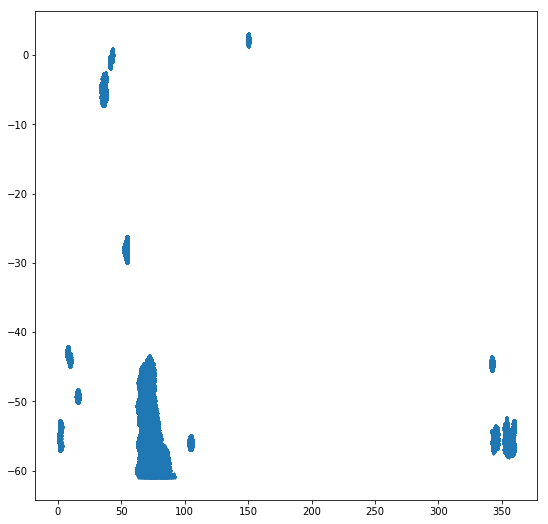

In [3]:
plt.rcParams['figure.figsize'] = (9,9)  # Change all subsequent figure sizes too.
plt.scatter(data['RA'], data['DEC'], s=0.01)
plt.show()

In [4]:
# Pick out just the main SV region to work with
mask = (data['RA'] > 50) & (data['RA'] < 100) & (data['DEC'] < -40) & (data['DEC'] > -65)
data = data[mask]
print(data.shape)

(16640983,)


In [180]:
# It's still pretty big, especially for some of the slower codes I want to compare to.
# Select a random million objects from this.
N = 1000000
indx = np.random.choice(len(data), size=N, replace=False)
ra = data['RA'][indx]
dec = data['DEC'][indx]
print(ra.shape, dec.shape)

(1000000,) (1000000,)


In [181]:
# Write out the smaller catalog, so we can skip the above steps in the future.
import treecorr
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')
cat.write('des_sv.fits')

In [182]:
# Now we can start here instead to save some time if we want.
import fitsio
import matplotlib.pyplot as plt
import numpy as np
import time
import coord
%matplotlib inline
import treecorr
import importlib
importlib.reload(treecorr)
plt.rcParams['figure.figsize'] = (9,9)
cat = treecorr.Catalog('des_sv.fits', ra_col='ra', dec_col='dec', ra_units='deg', dec_units='deg')
ra = cat.ra * (coord.radians / coord.degrees)
dec = cat.dec * (coord.radians / coord.degrees)

In [183]:
ra_rad = ra * (coord.degrees / coord.radians)
dec_rad = dec * (coord.degrees / coord.radians)
# Most codes don't know anything about Ra, Dec, so convert to x,y,z on unit sphere.
x, y, z = coord.CelestialCoord.radec_to_xyz(ra_rad, dec_rad)
xyz = np.array([x, y, z]).T

In [184]:
import matplotlib.cm as cm
npatch = 40
colors = cm.rainbow(np.linspace(0, 1, npatch))
np.random.shuffle(colors)

In [185]:
# Used scipy version 1.2.1
import scipy
from scipy.cluster.vq import kmeans, vq
t0 = time.time()
xyz = np.array([x, y, z]).T
cen, distortion = kmeans(xyz, npatch)
scipy_labels = vq(xyz, cen)[0]
t1 = time.time()
scipy_time = t1-t0
print('SciPy Version ',scipy.__version__)
print('Time = ',t1-t0)

SciPy Version  1.2.1
Time =  103.45589590072632


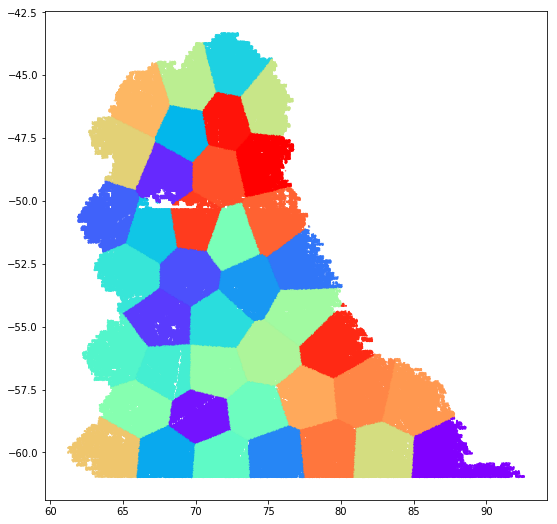

In [186]:
plt.scatter(ra, dec, color=colors[scipy_labels],s=0.1)
plt.show()

In [187]:
# Used scipy version 1.2.1
import scipy
from scipy.cluster.vq import kmeans2
t0 = time.time()
xyz = np.array([x, y, z]).T
# The default minit is 'random', which doesn't work on data that isn't rectangular
cen, scipy2_labels = kmeans2(xyz, npatch, minit='points')
t1 = time.time()
scipy2_time = t1-t0
print('SciPy Version ',scipy.__version__)
print('Time = ',t1-t0)

SciPy Version  1.2.1
Time =  2.813930034637451


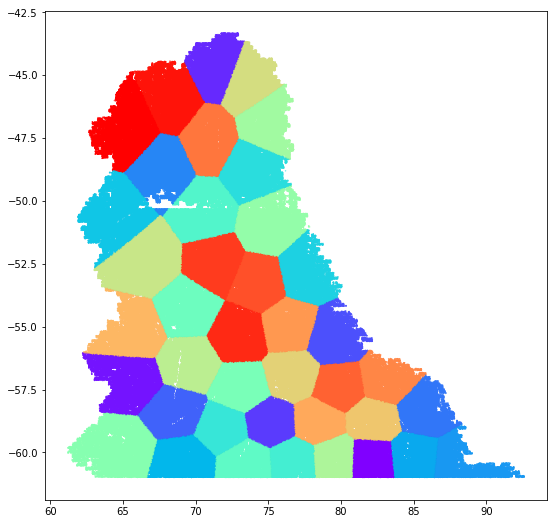

In [188]:
plt.scatter(ra, dec, color=colors[scipy2_labels],s=0.1)
plt.show()

In [189]:
# kmeans_radec is unversioned (at the time of running).  Used master branch commit 86151a9c2c04e.
import kmeans_radec
t0 = time.time()
radec = np.array([ra, dec]).T
km = kmeans_radec.kmeans_sample(radec, npatch, maxiter=100, tol=1.0e-5)
es_labels = km.labels
t1 = time.time()
es_time = t1-t0
print('Time = ',t1-t0)

X (2000, 2)  centers (40, 2)  tol=1e-05  maxiter=100
50 iterations  cluster sizes: [38 28 52 65 60 55 42 65 57 55 43 43 54 33 53 59 49 54 40 40 70 42 42 54
 44 50 43 71 34 46 64 54 58 28 24 63 49 75 73 31]
X (1000000, 2)  centers (40, 2)  tol=1e-05  maxiter=100
66 iterations  cluster sizes: [21739 19138 23534 25580 29074 28562 24357 29845 24133 23870 27563 26849
 22743 23162 27054 23438 22443 26891 24312 25392 25812 28432 25689 25982
 23683 35656 20147 20255 23833 23520 30396 25163 26498 21203 18104 29729
 21469 28078 25948 20724]
Time =  185.65048599243164


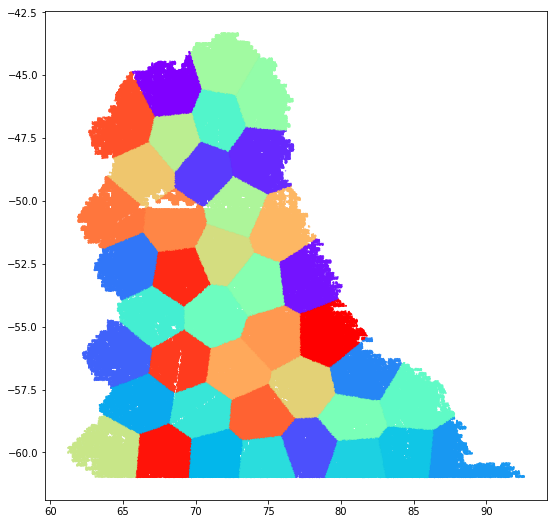

In [190]:
plt.scatter(ra, dec, color=colors[es_labels], s=0.1)
plt.show()

In [191]:
# Used pyclustering version 0.9.0  
# (Not available programmatically -- https://github.com/annoviko/pyclustering/releases/tag/0.9.0)
import pyclustering.cluster.kmeans
import pyclustering.cluster.center_initializer
# create instance of K-Means algorithm
t0 = time.time()
xyz = np.array([x, y, z]).T
pyc_centers = pyclustering.cluster.center_initializer.kmeans_plusplus_initializer(xyz, npatch).initialize();
# ccore=True is supposedly faster, but doesn't work on MacOS
kmeans_instance = pyclustering.cluster.kmeans.kmeans(xyz, pyc_centers, ccore=False)
# run cluster analysis and obtain results
kmeans_instance.process()
pyc_clusters = kmeans_instance.get_clusters()
pyc_labels = np.zeros_like(ra, dtype=int)
for i, cl in enumerate(pyc_clusters):
    pyc_labels[cl] = i
t1 = time.time()
pyc_time = t1-t0
print('Time = ',t1-t0)

Time =  97.39571690559387


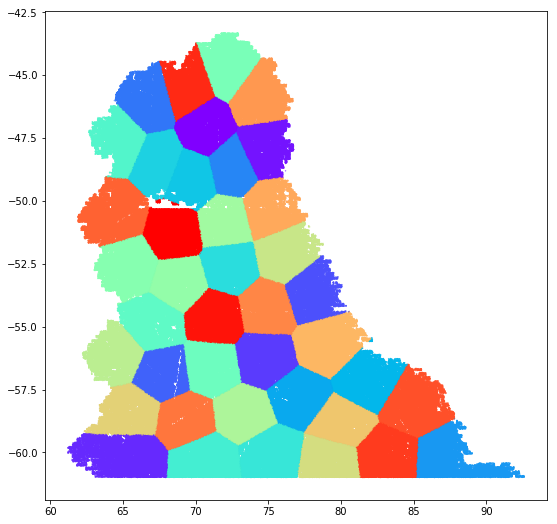

In [192]:
plt.scatter(ra, dec, color=colors[pyc_labels], s=0.1)
plt.show()

In [193]:
# Used sklearn version 0.20.0
import sklearn.cluster
t0 = time.time()
# By default, this wants to run 10 times and take the best, which makes it ridiculously slower than
# everything else here.  So just run one initialization instead.
sk_kmeans = sklearn.cluster.KMeans(n_clusters=npatch, n_init=1)
xyz = np.array([x, y, z]).T
sk_kmeans.fit(xyz)
sk_labels = sk_kmeans.labels_
t1 = time.time()
sk_time = t1-t0
print('ScikitLearn Version ',sklearn.__version__)
print('Time = ',t1-t0)

ScikitLearn Version  0.20.0
Time =  88.22348594665527


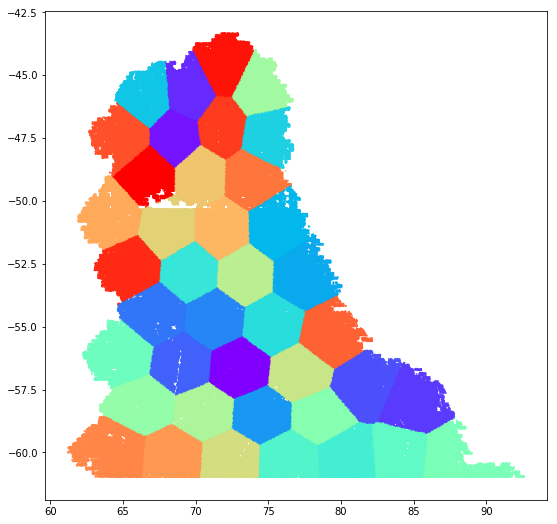

In [194]:
plt.scatter(ra, dec, color=colors[sk_labels], s=0.1)
plt.show()

In [195]:
# Used sklearn version 0.20.0
import sklearn
import sklearn.cluster
t0 = time.time()
mb_kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=npatch)
xyz = np.array([x, y, z]).T
mb_kmeans.fit(xyz)
mb_labels = mb_kmeans.labels_
t1 = time.time()
mb_time = t1-t0
print('ScikitLearn Version ',sklearn.__version__)
print('Time = ',t1-t0)

ScikitLearn Version  0.20.0
Time =  19.584288120269775


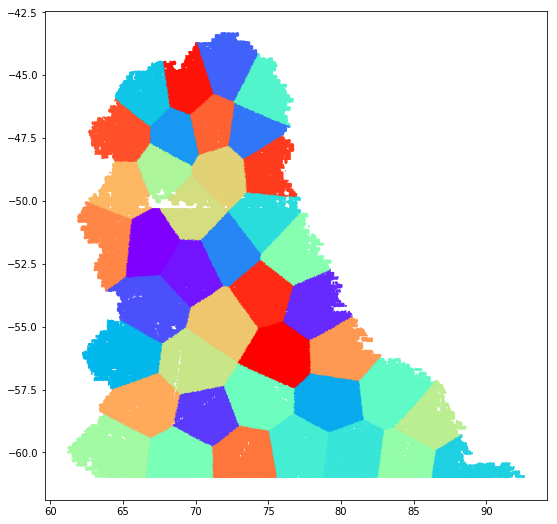

In [196]:
plt.scatter(ra, dec, color=colors[mb_labels], s=0.1)
plt.show()

In [197]:
t0 = time.time()
# repeat the Catalog creation to be fair for the timing comparison.
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')
field = cat.getNField()
tc_labels = field.run_kmeans(npatch)
t1 = time.time()
tc_time = t1-t0
print('Time = ',t1-t0)

Time =  1.8854808807373047


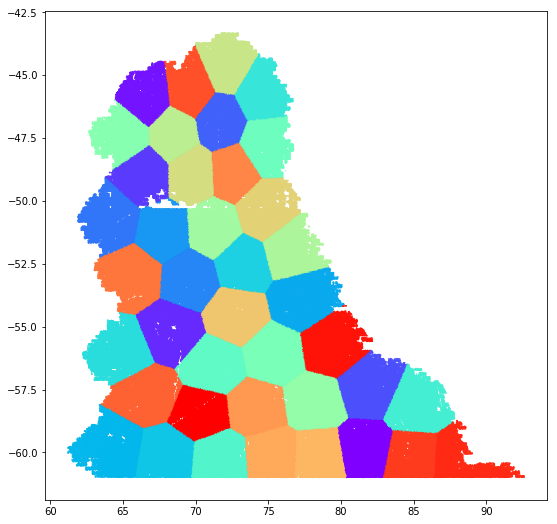

In [198]:
plt.scatter(ra, dec, color=colors[tc_labels], s=0.1)
plt.show()

In [199]:
# TreeCorr with the alternate algorithm
t0 = time.time()
# repeat the Catalog creation to be fair for the timing comparison.
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')
field = cat.getNField()
tc2_labels = field.run_kmeans(npatch, alt=True)
t1 = time.time()
tc2_time = t1-t0
print('Time = ',t1-t0)

Time =  2.064534902572632


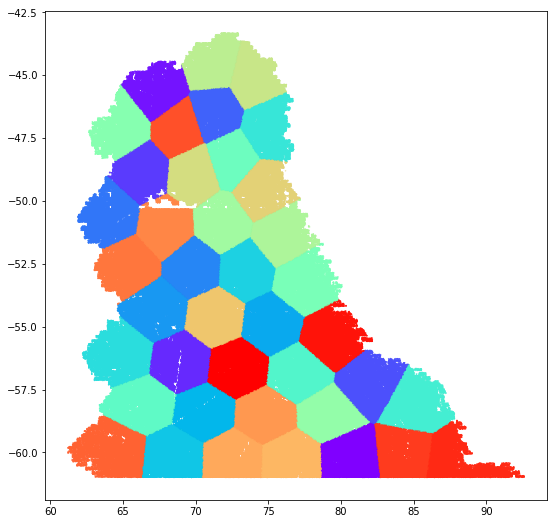

In [200]:
plt.scatter(ra, dec, color=colors[tc2_labels], s=0.1)
plt.show()

In [201]:
print('KMeans Code        Time    Inertia   RMS Intertia   Mean Size   RMS Size    RMS Counts   Counts Range')
print()
for name, labels, t in [('SciPy kmeans', scipy_labels, scipy_time),
                        ('SciPy kmeans2', scipy2_labels, scipy2_time),
                        ('KMeans_RADec', es_labels, es_time), 
                        ('PyClustering', pyc_labels, pyc_time),
                        ('SciKit KMeans', sk_labels, sk_time),
                        ('SK MiniBatch', mb_labels, mb_time),
                        ('TreeCorr def', tc_labels, tc_time),
                        ('TreeCorr alt', tc2_labels, tc2_time)]:
    cen = np.array([xyz[labels==i].mean(axis=0) for i in range(npatch)])
    inertia = np.array([np.sum((xyz[labels==i] - cen[i])**2) for i in range(npatch)])
    sizes = np.array([np.mean((xyz[labels==i] - cen[i])**2) for i in range(npatch)])**0.5
    sizes *= 180./np.pi * 60  # Convert to arcmin
    counts = np.array([np.sum(labels==i) for i in range(npatch)])
    print('%s\t %6.2f     %5.2f      %.3f         %.3f      %.3f        %.0f     %5d .. %d'%(
        name, t, np.sum(inertia), np.std(inertia),
        np.mean(sizes), np.std(sizes), np.std(counts),                                                    
        np.min(counts), np.max(counts)))
    with open('kmeans_stats.dat', 'a+') as f:
        f.write('%s  \t %8.4f \t %9.5f \t %9.5f \t %8.5e \t %8.5e \t %9.3f\n'%(
            name, t, np.sum(inertia), np.std(inertia), np.mean(sizes), np.std(sizes), np.std(counts)))


KMeans Code        Time    Inertia   RMS Intertia   Mean Size   RMS Size    RMS Counts   Counts Range

SciPy kmeans	 103.46     212.55      1.144         28.825      1.993        3501     17392 .. 31499
SciPy kmeans2	   2.81     230.13      3.178         28.751      4.854        6362     15698 .. 39512
KMeans_RADec	 185.65     212.86      1.369         28.759      2.483        3443     18104 .. 35656
PyClustering	  97.40     215.37      1.285         28.960      2.034        3853     16512 .. 34423
SciKit KMeans	  88.22     208.35      0.592         28.676      1.579        2502     20281 .. 29448
SK MiniBatch	  19.58     218.81      1.275         29.243      1.983        4377     14254 .. 35209
TreeCorr def	   1.89     210.40      0.732         28.790      1.928        2506     17210 .. 29031
TreeCorr alt	   2.06     209.58      0.270         28.823      1.437        2494     20420 .. 29883


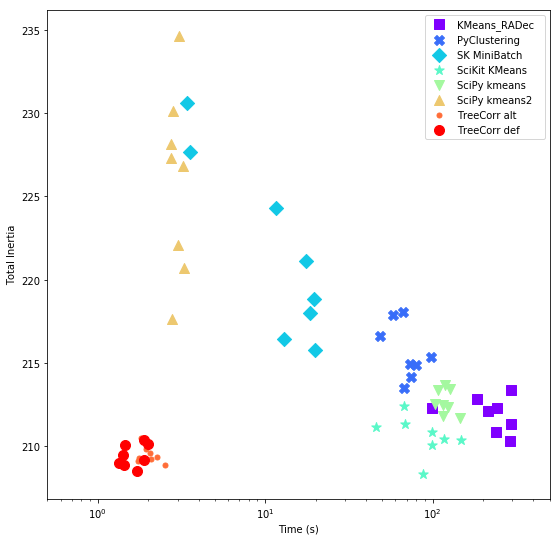

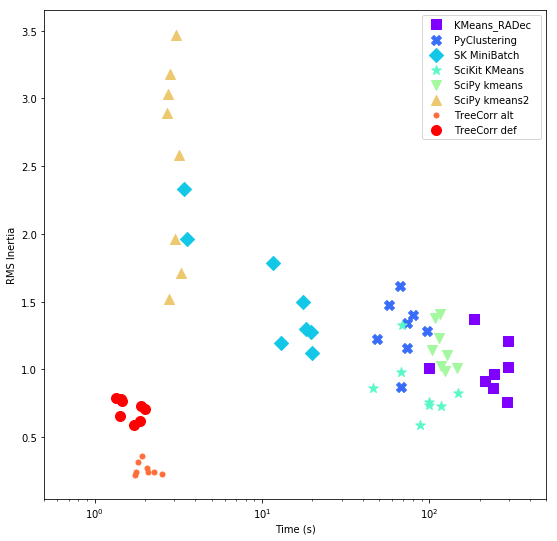

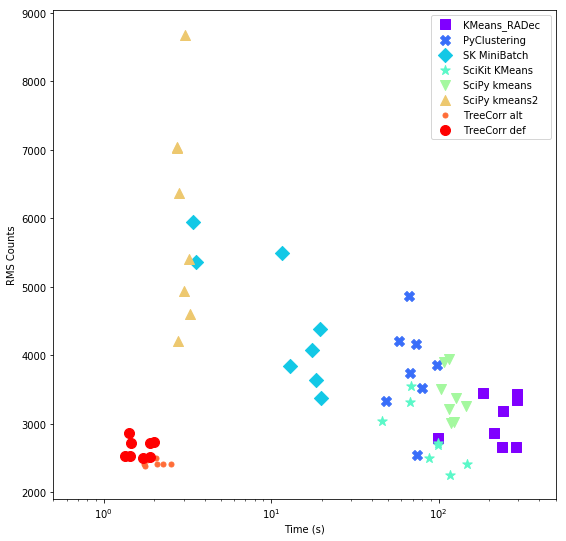

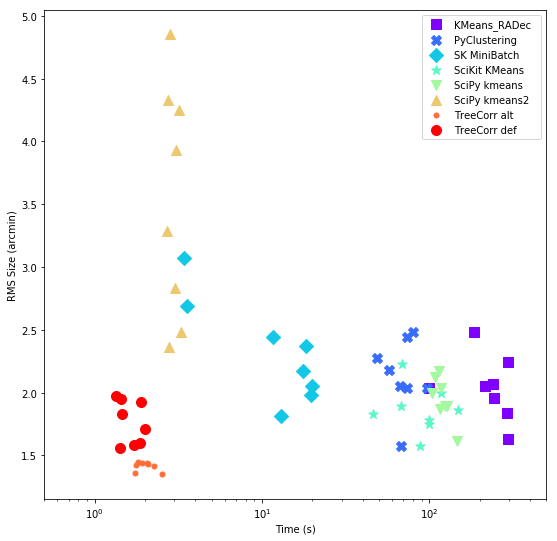

In [202]:
import matplotlib.patches as mp
stats = np.loadtxt('kmeans_stats.dat', 
                   dtype={'names': ('code', 'time', 'inertia', 'rms_inertia', 'mean_size', 'rms_size', 'rms_counts'),
                          'formats': ('U14', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4')},
                   delimiter='\t')
codes = np.unique(stats['code'])
stats_colors = cm.rainbow(np.linspace(0, 1, len(codes)))
markers = ['s', 'X', 'D', '*', 'v', '^', '.', 'o']
dots = []

for i, c in enumerate(codes):
    mask = stats['code'] == c
    dot = plt.scatter(stats['time'][mask], stats['inertia'][mask], s=100, c=[stats_colors[i]], marker=markers[i])
    dots.append(dot)
plt.xscale('log')
plt.xlim(0.5, 500)
plt.xlabel('Time (s)')
plt.ylabel('Total Inertia')
plt.legend(dots, codes, loc='upper right')
plt.show()

for i, c in enumerate(codes):
    mask = stats['code'] == c
    dot = plt.scatter(stats['time'][mask], stats['rms_inertia'][mask], s=100, c=[stats_colors[i]], marker=markers[i])
    dots.append(dot)
plt.xscale('log')
plt.xlim(0.5, 500)
plt.xlabel('Time (s)')
plt.ylabel('RMS Inertia')
plt.legend(dots, codes, loc='upper right')
plt.show()

for i, c in enumerate(codes):
    mask = stats['code'] == c
    dot = plt.scatter(stats['time'][mask], stats['rms_counts'][mask], s=100, c=[stats_colors[i]], marker=markers[i])
    dots.append(dot)
plt.xscale('log')
plt.xlim(0.5, 500)
plt.xlabel('Time (s)')
plt.ylabel('RMS Counts')
plt.legend(dots, codes, loc='upper right')
plt.show()

for i, c in enumerate(codes):
    mask = stats['code'] == c
    dot = plt.scatter(stats['time'][mask], stats['rms_size'][mask], s=100, c=[stats_colors[i]], marker=markers[i])
    dots.append(dot)
plt.xscale('log')
plt.xlim(0.5, 500)
plt.xlabel('Time (s)')
plt.ylabel('RMS Size (arcmin)')
plt.legend(dots, codes, loc='upper right')
plt.show()